# Base script for Ocean Parcels with various release and advection scenarios

Author: Johanna Wren

email: johanna.wren@noaa.gov

Date: May 16, 2018

This script advects particles in pre-defined locations at a pre-defined depth using HYCOM currents stored on file. The trajectories are saved as a net cdf file, then plotted on a map.

In [1]:
# Load libraries etc.
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, plotTrajectoriesFile, Variable, DiffusionUniformKh, AdvectionRK4
from parcels import rng as random
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
from datetime import datetime
import math

ModuleNotFoundError: ignored

## Create a fieldset
I'll show two different ways of loading data into parcels. One using current files stored on a harddrive, and one from an ERDDAP style repository. Pick one version, don't do both. If you choose to load from a file you have on your computer, then skip the "Load data from ERDDAP" or similar sections. 

The fieldset is what OceanParcels uses to store all the information it needs for the flowfield that it moves particles through.


### Load data stored on a drive
First we then instatiate a `FieldSet` with the velocity field data from global HYCOM dataset. These files are stored on your computer. 


In [ ]:
filenames = {'U': "HYCOM_Johnston_u.nc",
             'V': "HYCOM_Johnston_v.nc"}
variables = {'U': 'WATER_U',
             'V': 'WATER_V'}
dimensions = {'lat': 'LATITUDE1501_2001',
              'lon': 'LONGITUDE2126_2876',
              'depth': 'LEV1_5',
              'time': 'TIME'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

### Load data from ERDDAP or similar

This is a new function in parcels and uses `FieldSet.from_ds()` instead of the original `fieldset`. This enables parcles to load using xarray `Dataset` objects.

This way takes a bit of time since Parcels has to query the server that stores the current files, then generate the fieldset. But, it also takes time and space to download the currents ahead of time, so use the method that works best for you. 

First, start with getting the full dataset from HYCOM and look at what the extent and variables are:

In [ ]:
# create xarray Dataset of HYCOM velocities using ERDDAP
fname = 'http://apdrc.soest.hawaii.edu:80/dods/public_ofes/HYCOM/GLBu0.08/daily_snapshot'
ds = xr.open_dataset(fname, decode_times=True)
ds

/Users/johanna.wren/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:     (lat: 2001, lev: 40, lon: 4500, time: 7396)
Coordinates:
  * time        (time) datetime64[ns] 1992-10-02 1992-10-03 ... 2012-12-31
  * lev         (lev) float64 0.0 2.0 4.0 6.0 8.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 -80.0 -79.92 -79.84 -79.76 ... 79.84 79.92 80.0
  * lon         (lon) float64 -180.0 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
Data variables:
    water_u     (time, lev, lat, lon) float32 ...
    water_v     (time, lev, lat, lon) float32 ...
    water_temp  (time, lev, lat, lon) float32 ...
    salinity    (time, lev, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    title:          HYCOM global daily snapshot 0Z 1/12 degree reanalysis
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/hycom.php
    history:        Sat Nov 23 14:02:40 HST 2019 : imported by GrADS Data Ser...

In [ ]:
# Change coordinate system from +-180 to 360
ds.coords['lon'] = (ds.coords['lon']) % 360
# Then resorting the longitude 
ds = ds.sortby(ds.lon)
# Print the dataset to make sure it looks ok
ds

<xarray.Dataset>
Dimensions:     (lat: 2001, lev: 40, lon: 4500, time: 7396)
Coordinates:
  * time        (time) datetime64[ns] 1992-10-02 1992-10-03 ... 2012-12-31
  * lev         (lev) float64 0.0 2.0 4.0 6.0 8.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 -80.0 -79.92 -79.84 -79.76 ... 79.84 79.92 80.0
  * lon         (lon) float64 0.0 0.07996 0.16 0.24 ... 359.7 359.8 359.8 359.9
Data variables:
    water_u     (time, lev, lat, lon) float32 ...
    water_v     (time, lev, lat, lon) float32 ...
    water_temp  (time, lev, lat, lon) float32 ...
    salinity    (time, lev, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    title:          HYCOM global daily snapshot 0Z 1/12 degree reanalysis
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/hycom.php
    history:        Sat Nov 23 14:02:40 HST 2019 : imported by GrADS Data Ser...

Then subset the data in space and time to what you want for your application. Here we are focusing on Jonhston Atoll and will work with two months worth of data at first. 

This takes some time so be mindful what time and spatial extent you really need. 

In [ ]:
# Define start and end dates you need currents for
startDate = datetime(2011,1,1)
endDate = datetime(2011,3,1)

Then we subset and save the subset as `v`. Make sure it is what you want. You can click on the files and stack icons to the right once you run the below code to get more information about the data.

In [ ]:
# Subset data
v = ds.sel(time=slice(startDate, endDate), lev=0, lon=slice(170,220), lat=slice(0,40))
v

<xarray.Dataset>
Dimensions:     (lat: 501, lon: 626, time: 60)
Coordinates:
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-03-01
    lev         float64 0.0
  * lat         (lat) float64 0.0 0.08 0.16 0.24 0.32 ... 39.76 39.84 39.92 40.0
  * lon         (lon) float64 170.0 170.1 170.2 170.2 ... 219.8 219.9 220.0
Data variables:
    water_u     (time, lat, lon) float32 ...
    water_v     (time, lat, lon) float32 ...
    water_temp  (time, lat, lon) float32 ...
    salinity    (time, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    title:          HYCOM global daily snapshot 0Z 1/12 degree reanalysis
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/hycom.php
    history:        Sat Nov 23 14:02:40 HST 2019 : imported by GrADS Data Ser...

In [ ]:
# add attributes to lon variable. Not sure this is necessary, but doing it anyway. 
v.lon.attrs = {'grads_dim': 'x',
 'grads_mapping': 'levels',
 'grads_size': '4500',
 'units': 'degrees_east',
 'long_name': 'longitude',
 'minimum': 170,
 'maximum': 220,
 'resolution': 0.08000001}

v

<xarray.Dataset>
Dimensions:     (lat: 501, lon: 626, time: 60)
Coordinates:
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-03-01
    lev         float64 0.0
  * lat         (lat) float64 0.0 0.08 0.16 0.24 0.32 ... 39.76 39.84 39.92 40.0
  * lon         (lon) float64 170.0 170.1 170.2 170.2 ... 219.8 219.9 220.0
Data variables:
    water_u     (time, lat, lon) float32 ...
    water_v     (time, lat, lon) float32 ...
    water_temp  (time, lat, lon) float32 ...
    salinity    (time, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    title:          HYCOM global daily snapshot 0Z 1/12 degree reanalysis
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/hycom.php
    history:        Sat Nov 23 14:02:40 HST 2019 : imported by GrADS Data Ser...

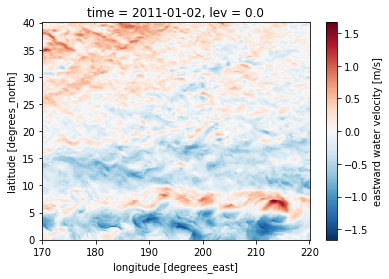

In [ ]:
# Subset data v to just the water_u variable for the first timestep
u_t1 = v.water_u.isel(time=1)
# Plot to make sure the lon conversion worked properly
u_t1.plot()

Then we construct the fieldset. This is the same way you would do it above (reading in currents you have stored on your computer), but the variable names are a bit different. You get the variable names from the `v` dataset and they should be shown above. Depth here is called `LEV`. 

Running the code chunk below will take some time so be patient! 

<span style="color:darkgreen">*Once you have generated a fieldset you can save it using `write(fieldset)` and once it's saved, you can skip all of this and just read it in as `FieldSet.from_parcels()`*</span>

In [ ]:
%%time
# Convert Dataset to Parcels FieldSet
variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'depth': 'lev',
              'time': 'time'}

fieldset = FieldSet.from_xarray_dataset(v, variables, dimensions)

Run some diagnostics on the `fieldset` to make sure it is read in properly. If your dataset is straddeling the 180 longitude, Parcels might plot the map in +-180 so the fieldset isn't continuous geographically, but that is just the plotting function, it still works fine and advects across the 180 meridian. 

In [ ]:
# Plot the U field
fieldset.U.show()
#print(fieldset.U.lon)

## Add diffusivity
In order for diffusivity to be incorporated we need to add zonal and meridional Kh fields. This code uses spatially homogenous diffusivity, but if you want spatially varying diffusivity use the `AdvectionDiffusionEM` or `AdvectionDiffusionM1` kernel instead.

Skip the next cell if you want to run without diffusivity. 

In [ ]:
kh = 10   # This is the eddy diffusivity in m2/s

# Add even diffusivity to the fieldset
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical')            

## Set particle release locations
Next, we instantiate a `ParticeSet` composed of `JITParticle`. 

`ParticleSet` holds release locations, the number of particles released, the release depth, and how often a particel should be released (daily, every 6h, etc.)

<span style="color:darkgreen">**I'm showing a few different scenarios below. Pick one at a time and play around with them!**</span>

### Release along a line
Particle release locations are spaced along a straight line. Particles can have the same or different release depths. 

You can omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

<span style="color:red">For some reason I cannot get the `time` part of the ParticleSet to work. The default is the first date in the fieldset, so the first day for which you have currents, so I'm leaving it there for now. But, you should be able to read in a different start date here... It works in a different script but not in this one for some reason.</span>

In [ ]:
type(start_date)

In [ ]:
# Number of particles
npart = 10
# Depth of particles
pdepth = [0] * npart
# Start and end of the line along which we are releasing
start_line = (190, 10)
end_line = (190, 20)
# Interval between releases (in seconds).
release_int = 86400
# Start date for release
start_date = datetime(2011,1,15)

# Define the pset
pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=JITParticle,
                             size=npart, 
                             depth=pdepth,
                             start=start_line, 
                             finish=end_line, 
                             time=start_date, 
                             repeatdt=release_int)


Here we print the `pset` to make sure it looks ok. I also like to plot it on a map, but again, this might not look right with the +-180 issue, so look at the numbers that are printed from the `pset` if the map looks wrong

In [ ]:
print(pset)
pset.show()

### Release at a point location
Particle release location is a single point. We release `npart` particels at a defined depth `pdepth` every `release_int` seconds. 

You can omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

In [ ]:
# Single lat_long
lat = [16.736944]
lon = [190.476111]
# Number of particles released
npart = 10
# Particle release depth
pdepth = [0]
# Time interval between particle release (in seconds)
release_int = 86400
# Start date for release
start_date = datetime(2011,1,15)

# Define the pset
pset = ParticleSet(fieldset=fieldset, 
                   pclass=JITParticle, 
                   lat=np.tile(lat,npart), 
                   lon=np.tile(lon,npart), 
                   depth=pdepth*npart,
                   time=start_date,
                   repeatdt=release_int)

In [ ]:
# Print the pset to see if it looks ok
print(pset)
pset.show()

### Release from a uniform grid
Release locations are spaced out on a grid. Particels are released on the `lons, lats` grid at `pdepth` every `release_int` seconds starting on `start_date`.

You can omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

In [ ]:
# Define corner locations of the grid
latmax = 18
latmin = 15
lonmax = 200
lonmin = 180
# Resolution of the grid
res = 2
# Make grid using numpy
lons, lats = np.meshgrid(range(lonmin, lonmax, res), range(latmin, latmax, res))
# Set release depth
pdepth = [0]*(lons.shape[0]*lons.shape[1])
# Time interval between particle release (in seconds)
release_int = 86400
# Start date for release
#start_date = datetime(2018, 1, 1)

# Define the pset
pset = ParticleSet(fieldset=fieldset, 
                   pclass=JITParticle, 
                   lon=lons, 
                   lat=lats,
                   depth=pdepth, 
                   time=start_date,
                   repeatdt=release_int)


In [ ]:
print(pset)
pset.show()

### Release from locations in a file
Particles are released from locations specified in a file. We use this if we want to release at for example all reef locations in the islands, or any other list of locations. 

This code is a bit crude, it's modified from the code reading in release locations in Don's and my model. I'm sure it can be updated and made more efficient. 

You can omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

In [ ]:
# Set input file
infile = "MHIreefsNew.csv"

release_site = pd.read_csv(infile)
habilon = release_site[0]
habitlat = release_site[1]

# Time interval between particle release (in seconds)
release_int = 86400
# Start date for release
start_date = datetime(2011, 1, 1)

# Define the pset
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=JITParticle, 
                             lon=habilon, 
                             lat=habilat, 
                             time=start_date)

### Visualize particle start locations
We can now see where the particles are seesed by using `pset.show` 

In [ ]:
print(pset)
pset.show()

## Advect particles

Because particles may exit the domain, we will invoke a function that removes all particles that exit the domain.

In [ ]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

If you are using diffusion in combination with an advection kernel you need to combine them and this bit of code does that.

We use a Runge-Kutta 4th order advection `AdcectionRK4`. 
* If we want a 3D advection use `AdvectionRK4_3D` instead which I don't believe can be used with a 2D diffusion but I'm not certain. 

In [ ]:
# Combine diffusivity kernel with RK4 advection kernel
kernels = pset.Kernel(DiffusionUniformKh) + pset.Kernel(AdvectionRK4)

# If you want to run advection without diffusion run the following line istead:
# kernels = pset.Kernel(AdvectionRK4)
# or for 3D advection:
# kernels = pset.Kernel(AdvectionRK4_3D)

Execute the advection. Depending on how many particles you release and the length of your release this may take some time. 

Particles specified in `ParticleSet` are advected using `kernels` at a `model_dt` time step and printed in a netcdf file (`outfile`) at `save_dt` time steps. Particels reaching the limits of the domain are removed through `recovery`. 

In [ ]:
# Set output file name
outfile = "HYCOMtest2018_AdvWDiff_point.nc"
# Time step in model
model_dt = timedelta(minutes=5)
# Time step to save to file
save_dt = timedelta(hours=3)
# Length of model run
run_days = 30

# Execute
pset.execute(kernels,
            runtime=timedelta(days=run_days),
            dt=model_dt, 
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            output_file=pset.ParticleFile(name=outfile, outputdt=save_dt))

To make sure particles have been advected run `pset.show()` again. 

In [ ]:
pset.show()

## Visualize the dispersal

### Plot trajectories
Plot the trajectories saved to the netcdf file `outfile` on a map. It's not going to be pretty, but it gives you an idea if the dispersal made sense or not. 

In [ ]:
plotTrajectoriesFile(outfile)

### U-velocity field with point locations
Velocity field here is static. 

In [ ]:
# Plot point locations on a defined domain.
pset.show(field=fieldset.U, domain=[20, 15, 180, 170], land=True, with_particles=True)

### Vector field with point locations

By setting the `field` argument equal to `vector`, we can display the velocity in full vector form. These vector fields are static. 

* For high resolution files with a large spatial extent this looks intense and it's hard to see the vector fields. 

I wrote a script to plot locations and trajectories on daily vector fields in R called _TrajectoryPlotting.Rmd_ that takes Ocean Parcels output netcdf files. It's a good alternative to plotting using Ocean Parcels and it allows for plotting of different depths which I have had a hard time with in python/OceanParcels

In [ ]:
pset.show(field='vector')

By reducing the spatial domain we can see that it's indeed a vector field, but it's still not pretty. 

The normalized vector field is colored by speed. To control the maximum speed value on the colorbar, set the `vmax` argument equal to the desired value.

This bit of code also uses pythons **Basemap** modules land mask to mark land when `land=True` is set.

In [ ]:
pset.show(field='vector', vmax=1.0, domain=[20, 15, 180, 170], land=True)

### 3D plotting

<span style="color:red">This bit isn't really relevant since we are only moving particles in 2D but left it in if you are curious how to plot outside of the built in parcles plot functions (that look terrible thanks to the +-180 ploting issue) </span>

Visualizing trajectories in 3D can be helpful when running `AdvectionRK4_3D`. This visulaization is done using **matplotlib** and is not an out-of-the-box Ocean Parcels plotting kernel. The code is modified from the [Argos float tutorial](http://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_Argofloats.ipynb) included in Ocean Parcels. 

the % commands are special jupyter notebook functions and here we use `%matplotlib notebook` to make the plot interactive, so you can rotate it and freeze at a prefered angle. 

In [ ]:
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# this makes it interactive
%matplotlib notebook   

outfile3D = "HYCOMtest2011_3D.nc"

nc = netCDF4.Dataset(outfile3D)
x = nc.variables["lon"][:]
y = nc.variables["lat"][:]
z = nc.variables["z"][:]
n = nc.variables["trajectory"][:]
nc.close()

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
cb = ax.scatter(x, y, z, c=n, s=10, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z),0)
plt.show()
